# Scrapbook

Imports

In [1]:
import os
import shutil
import pickle
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

from skimage import io
import cv2

Constants

In [10]:
RAW_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw')
DATA_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_info.csv')

PROCESSED_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 
                                   'processed', 'data_to_tf_data.npy')
PROCESSED_LABELS_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 
                                     'processed', 'labels_to_tf_data.npy')


Loading in the data

In [3]:
painting_data = pd.read_csv(DATA_CSV_PATH)

Rewriting stuff into functions

In [17]:
new_styles_array = ['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
                    'Art Nouveau (Modern)', 'Baroque', 'Surrealism', 'Symbolism',
                    'Cubism', 'Ukiyo-e']

In [18]:
def _get_names_and_styles(styles, num_images_per_class=2):
    images_array = []
    labels_array = []

    for style in styles:
        concatenate_images = painting_data[painting_data['style'] == style].head(num_images_per_class)['filename'].values
        concatenate_labels = painting_data[painting_data['style'] == style].head(num_images_per_class)['style'].values
        images_array = np.append(images_array, concatenate_images)
        labels_array = np.append(labels_array, concatenate_labels) 
    
    return images_array, labels_array    

In [19]:
def _prepare_img_data(array_of_imgs, array_of_labels, img_width=200, img_height=200):
    X = []
    y = []
    
    for image, label in zip(array_of_imgs, array_of_labels):
        current_file = os.path.join(RAW_DATA_PATH, image)
        
        try:
            X.append(np.array(cv2.resize((cv2.imread(current_file, cv2.IMREAD_GRAYSCALE)), 
                                         (img_width, img_height))))
            y.append(label.upper())
        except Exception as e:
            print(f"Corrupted image: {image}, skipping the image")
            print(e)
    
    return X, y

In [20]:
def _save_data_and_labels(data, labels, data_path=PROCESSED_DATA_PATH, labels_path=PROCESSED_LABELS_PATH):
    np.save(data_path, data)
    np.save(labels_path, labels)

Now putting it all together.

In [21]:
def preprocess_data():
    
    new_styles_array = ['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
                        'Art Nouveau (Modern)', 'Baroque', 'Surrealism', 'Symbolism',
                        'Cubism', 'Ukiyo-e']
    
    images_array, labels_array = _get_names_and_styles(new_styles_array)
    
    data, labels = _prepare_img_data(images_array, labels_array)
    
    _save_data_and_labels(data=data, labels=labels)

In [22]:
preprocess_data()

Sanity check 

In [11]:
X = np.load(PROCESSED_DATA_PATH)
y = np.load(PROCESSED_LABELS_PATH)

In [12]:
unique, count = np.unique(y, return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = \n{occurences}")

The number of occurences of each class in the dataset = 
{'ART NOUVEAU (MODERN)': 1100, 'BAROQUE': 1100, 'CUBISM': 1100, 'EXPRESSIONISM': 1100, 'IMPRESSIONISM': 1100, 'REALISM': 1100, 'ROMANTICISM': 1100, 'SURREALISM': 1100, 'SYMBOLISM': 1100, 'UKIYO-E': 1098}


In [13]:
len(X)

10998

In [7]:
print(y[:2])

['IMPRESSIONISM' 'IMPRESSIONISM']


In [5]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(3, 3, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(0, len(label_data))
            image = images[index]
            label = labels[index]
            axis.imshow(image, cmap='Greys')
            axis.set_title(f"Class: {label}")
            axis.set_axis_off()

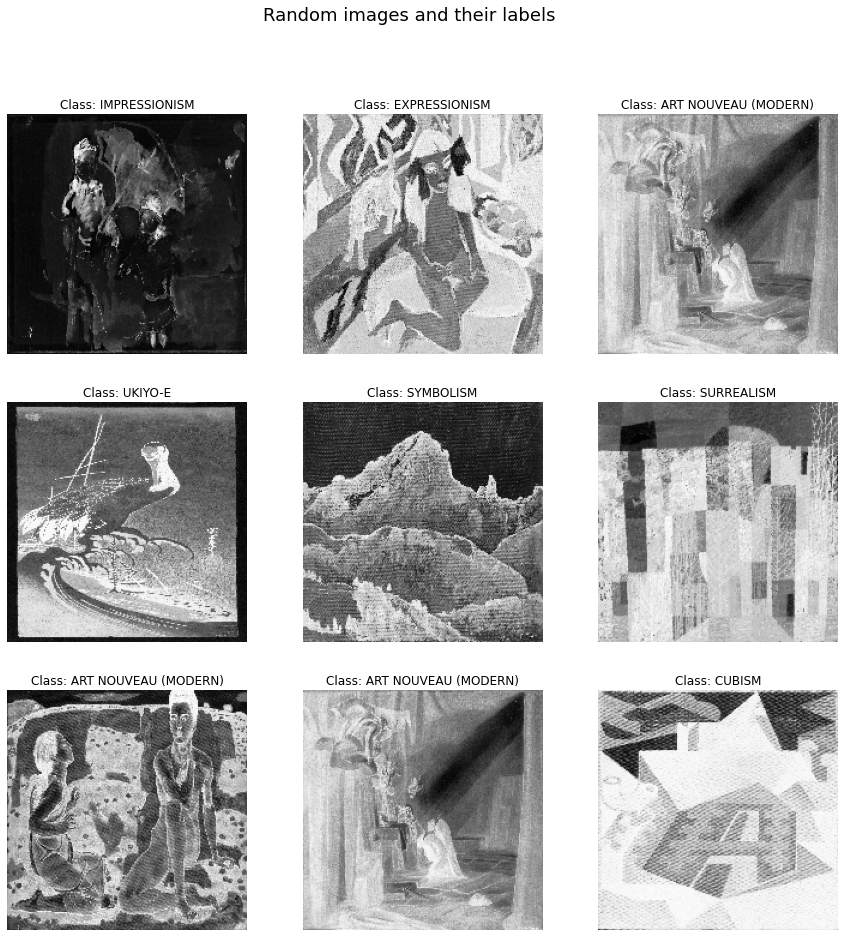

In [6]:
display_rand_imgs(X, y, 7)

In [10]:
print(tf.__version__)

2.1.0


In [19]:
X = np.load(PROCESSED_DATA_PATH)
y = np.load(PROCESSED_LABELS_PATH)

In [20]:
X.shape, y.shape

((600, 200, 200), (600,))

In [21]:
X = X.reshape(-1, 200, 200, 1).astype('float32')
X = X / 255.

In [22]:
X.shape, y.shape

((600, 200, 200, 1), (600,))

In [23]:
some_test_dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [24]:
cardinality_count = tf.data.experimental.cardinality(some_test_dataset).numpy()
cardinality_count

600

In [17]:
def _normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image

In [102]:
def _load_image(some_image):
    input_image = tf.image.resize(some_image, [200, 200, 1])  # add num_channels here?
    input_image = tf.cast(input_image, tf.float32) / 255.0

#     input_image = self._normalize(input_image)
    return input_image

In [25]:
# result = some_test_dataset.map(lambda image, label: _normalize(image))
# list(result.as_numpy_iterator())

In [26]:
for images, labels in some_test_dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

print(numpy_images)

[[[0.4       ]
  [0.4862745 ]
  [0.46666667]
  ...
  [0.5019608 ]
  [0.5019608 ]
  [0.5058824 ]]

 [[0.37254903]
  [0.34509805]
  [0.34117648]
  ...
  [0.5254902 ]
  [0.5411765 ]
  [0.5568628 ]]

 [[0.40784314]
  [0.39215687]
  [0.5019608 ]
  ...
  [0.47843137]
  [0.4745098 ]
  [0.5058824 ]]

 ...

 [[0.3254902 ]
  [0.30588236]
  [0.29411766]
  ...
  [0.18431373]
  [0.17254902]
  [0.19215687]]

 [[0.3372549 ]
  [0.34117648]
  [0.29803923]
  ...
  [0.15686275]
  [0.1882353 ]
  [0.19607843]]

 [[0.3647059 ]
  [0.3019608 ]
  [0.3254902 ]
  ...
  [0.16862746]
  [0.17254902]
  [0.18431373]]]


In [27]:
DATASET_SIZE = 600

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

some_test_dataset = some_test_dataset.shuffle(100)

train_dataset = some_test_dataset.take(train_size)
test_dataset = some_test_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [28]:
tf.data.experimental.cardinality(train_dataset).numpy()

420